In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [2]:
res_shp = codebase.load_data.load_GRanD()

In [3]:
from codebase import volume_pipeline

In [4]:
# Step 1 wrapper function works
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('Indirasagar',res_shp)

In [5]:
# Step 2 function works
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)

In [6]:
# Step 3 single timestep and vectorized work.
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA)

# Testing out vectorization of Step 3 (label as expand/shrink for each timestep)
test_vectorized = xr.apply_ufunc(volume_pipeline.decide_expansion_or_shrinkage_timestep,
                                 fw_diff_DA,input_core_dims=[['lat','lon']],vectorize=True)

In [7]:
# Step 4 wrapper function works
from scipy.stats import norm
change_cond_time0 = change_cond_DA.isel(time=0)
fw_diff_time0 = fw_diff_DA.isel(time=0)
fw_time0 = fw_DA.isel(time=0)
start_params = volume_pipeline.fit_DEM_distribution_from_conditional_area(dem_DA, fw_time0, 1, norm)
change_params = volume_pipeline.fit_DEM_distribution_from_conditional_area(dem_DA, fw_diff_time0, change_cond_time0, norm)
print('params of start timestep:',start_params)
print('params of change in area:',change_params)

params of start timestep: (257.2609612698588, 17.42481840990914)
params of change in area: (259.5148348731124, 16.753825029340693)


In [8]:
## Could not vectorize the Step 4 function(s). Skipped vectorization and made for loop functions :(

# from xarray import DataArray
# def grab_DEM_of_conditional_area(
#     dem_DA: DataArray, cond_DA: DataArray, cond: int = 1
# ) -> DataArray:
#     print(type(dem_DA), type(cond_DA) , cond)
#     print(dem_DA.shape)
#     dem_cond_area = dem_DA.where(cond_DA == cond)
#     return dem_cond_area


# xr.apply_ufunc(grab_DEM_of_conditional_area,
#                fw_DA,input_core_dims=[['lat','lon']],kwargs={'dem_DA':dem_DA},
#               vectorize=True, output_core_dims=['time'])

# xr.apply_ufunc(volume_pipeline.fit_DEM_distribution_from_conditional_area,
#                dem_DA,fw_DA[:-1,:,:],change_cond_DA,norm,
#               input_core_dims=[['lat','lon'],['lat','lon'],[],[]],
#               vectorize=True, join='right')

In [9]:
test_params = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA,fw_diff_DA,change_cond_DA,norm)

In [10]:
test_heights = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(dem_DA,fw_DA,fw_diff_DA,change_cond_DA)

In [11]:
test_heights

array([ 2.2538736 ,  3.22785457,  0.        ,  3.21247809,  0.        ,
        0.        ,  0.        ,  0.        ,  9.18580973,  1.93724739,
        4.41165882,  0.        ,  2.01616188, -0.09478783, -0.70998637,
        0.40404311,  0.        ,  0.        ,  0.        ,  0.        ,
        5.67006389,  3.55463398,  0.        ,  1.03288812,  4.2520552 ,
        5.07889366,  1.04772569,  0.        ,  0.98399098, -5.5835981 ,
        0.        , 11.95120005,  5.34048783,  6.34050226,  0.        ,
        0.        ,  4.01452676,  8.09488435, -0.18180305,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  6.8779303 ,
        0.        ,  0.72629526,  0.        ,  4.09133566, -1.71592322,
       -2.3914336 ,  1.34487293,  0.        ,  0.        ,  9.62515123,
        0.        ])

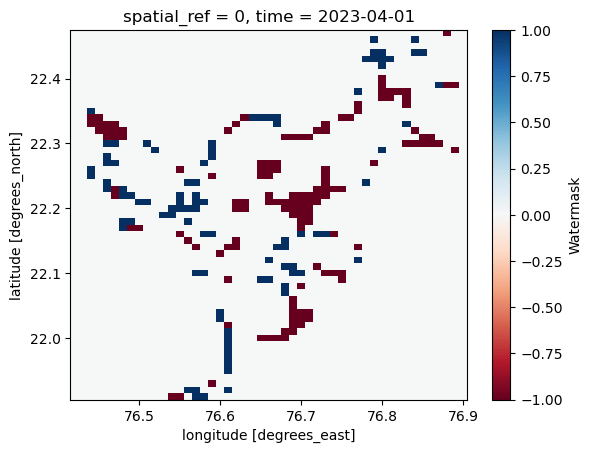

In [12]:
fw_diff_DA.isel(time=-1).plot(cmap='RdBu')

In [13]:
test_params[0]

(259.5148348731124, 16.753825029340693)

In [14]:
def calculate_rough_area(input_DA):
    """
    Placeholder function while I get the pipeline up and running.
    Should replace with function(s) project into 2D space.
    """
    pixel_count = input_DA.sum()
    area_deg2 = 0.01 *0.01 * pixel_count
    return area_deg2

In [15]:
volume_pipeline.calculate_rough_area_vectorize(fw_DA)

<xarray.DataArray 'Watermask' (time: 57)>
array([0.0549, 0.0683, 0.1052, 0.1063, 0.0928, 0.0981, 0.1004, 0.0955,
       0.0954, 0.0757, 0.0578, 0.032 , 0.0348, 0.0599, 0.0822, 0.1018,
       0.0776, 0.0706, 0.0791, 0.0809, 0.0738, 0.0643, 0.0552, 0.0536,
       0.039 , 0.0714, 0.0933, 0.0817, 0.082 , 0.0668, 0.0819, 0.0795,
       0.0721, 0.0621, 0.0471, 0.0468, 0.0484, 0.0617, 0.0842, 0.0719,
       0.0639, 0.0706, 0.0722, 0.0722, 0.0667, 0.0574, 0.0513, 0.0396,
       0.0445, 0.0573, 0.0814, 0.0985, 0.0863, 0.0776, 0.0833, 0.0739,
       0.0698])
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2018-08-01 2018-09-01 ... 2023-04-01

In [25]:
test_reproj = fw_DA.rio.reproject("ESRI:54017")

In [38]:
input_DA = fw_DA
x_dim = "lon"
y_dim = "lon"
_x = input_DA.coords[x_dim]
_y = input_DA.coords[y_dim]

_x_widths = np.unique((_x[1:].values - _x[:-1].values).round(decimals=4))
_y_widths = np.unique((_y[1:].values - _y[:-1].values).round(decimals=4))

In [41]:
test_reproj.spatial_ref.grid_mapping_name

'lambert_cylindrical_equal_area'

In [30]:
check_equal_area_DA(fw_DA,"lon","lat")

False

In [20]:
codebase.area_calcs.CYGNSS_001_areal_average(fw_DA)

Projected to equal area


array([0.19242311, 0.23630908, 0.37284321, 0.37284321, 0.3255814 ,
       0.34771193, 0.35596399, 0.33420855, 0.33570893, 0.26631658,
       0.20367592, 0.11590398, 0.12303076, 0.21117779, 0.28994749,
       0.35821455, 0.27044261, 0.24343586, 0.27531883, 0.28132033,
       0.25843961, 0.22580645, 0.19429857, 0.19392348, 0.13690923,
       0.24943736, 0.33008252, 0.28357089, 0.28357089, 0.22618155,
       0.28694674, 0.28057014, 0.25656414, 0.22130533, 0.17141785,
       0.16954239, 0.16354089, 0.21642911, 0.29632408, 0.25431358,
       0.22355589, 0.2468117 , 0.25131283, 0.24981245, 0.23668417,
       0.20742686, 0.18229557, 0.13953488, 0.15453863, 0.20405101,
       0.2891973 , 0.34546137, 0.29894974, 0.27044261, 0.29069767,
       0.25768942, 0.2468117 ])